# Create plots for panels used in figure 1

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.collections import PathCollection
import seaborn as sns
import dclab
from lin_mixed_model import linmixmod

import warnings
warnings.filterwarnings('ignore')

Available binaries: ['C:\\Program Files\\R\\R-4.1.2\\bin\\i386\\R.exe']
Using R:  C:\Program Files\R\R-4.1.2\bin\i386\R.exe


In [3]:
# folder where all panel plots for figure 1 will be stored
savefolder = r"plots\fig1"

### Panels A and B

In [4]:
#define a color seed for each patient
color_dict = {'VS': 'C0', 'VL': 'C1', 'RS': 'C2',
              'KM': 'C3', 'LM': 'C4'}

In [5]:
def asymptotic_exponential_growth(x, lambda_):
    """(Inverted) exponential growth function with maximum at 1 for x->infinity:
    f(x) = 1 - exp(-lambda * x)"""
    return 1 - np.exp(-lambda_ * x)

def deformed_probability_curve(df, v_min=0, v_max=3, binsize=.25):
    """Compute the values for the shape probability diagram to find a cell
    in a deformed state for velocities between v_min and v_max in the DataFrame df

    returns: *tuple* (deformed_bins, deformed_hist_normal)
        - deformed_bins: *array* limits for the bin ranges of the histogram
        - normalized counts for each velocity range
    """

    bins = int(v_max/binsize)   #number of Bins in histogram
    #find index of cells in a deformed state. Class definitions are:
    #1-parachute, 2-slipper, 3-asym. parachute, 5-multilobe, 7-undefined deformed
    #4-discocyte/undeformed, 6-tumbler
    deformed_index = ((df['shape'] == 1)
                      | (df['shape'] == 2)
                      | (df['shape'] == 3)
                      | (df['shape'] == 5)
                      | (df['shape'] == 7))

    #create new column in df that is True for deformed state
    df['deformed'] = False
    df['deformed'][deformed_index] = True

    df_deformed = df[deformed_index]

    deformed_hist, deformed_bins = np.histogram(np.array(df_deformed['velocity']),
                                                range = (v_min,v_max),
                                                bins = bins)
    #get the counts for all events to use for normalization
    all_hist, all_bins = np.histogram(np.array(df['velocity']),
                                      range = (v_min,v_max),
                                      bins = bins)

    #normalize the deformed histogram
    deformed_hist_normal = deformed_hist/all_hist

    return deformed_bins, deformed_hist_normal

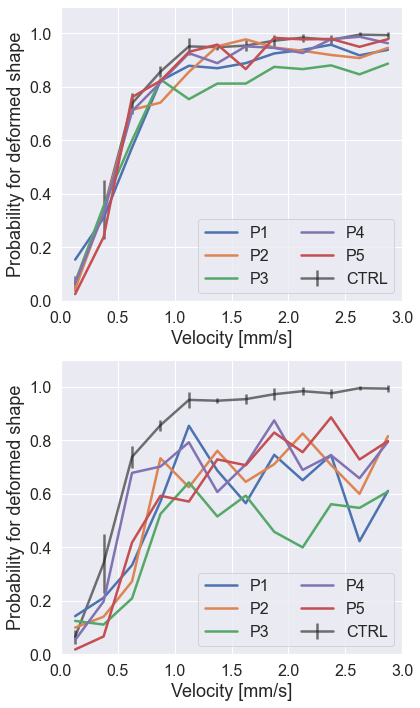

In [27]:
warnings.filterwarnings('ignore')

patients = ['VS', 'VL', 'RS', 'LM', 'KM']
labels = ["P1", "P2", "P3", "P4", "P5"]

result_summary_folder = r"data\shape_analysis\result_summaries"

lw = 2.5
xlabel = "Velocity [mm/s]"
ylabel = "Probability for deformed shape"
fontsize = 18
color_ctrl = 'k'
alpha_ctrl = .6
lw_ctrl = 2.5

v_min = 0.
v_max = 3.
binsize = 0.25

figsize = (6, 10)

with sns.axes_style('darkgrid'):
    fig = plt.figure(0, figsize)

    #plot control curves
    #load data from txt file
    results_ctrl = np.loadtxt(r"data\shape_analysis\histograms_HealthyControl_deformed_undeformed.txt")

    v_ctrl = results_ctrl[:,0]
    probs_ctrl = results_ctrl[:,3]
    probs_ctrl_err = results_ctrl[:,4]

    ind_vmax = v_ctrl <= v_max
    v_ctrl = v_ctrl[ind_vmax]
    probs_ctrl = probs_ctrl[ind_vmax]
    probs_ctrl_err = probs_ctrl_err[ind_vmax]

    for i in range(2):
        plt.subplot(2,1,i+1)
        plt.errorbar(v_ctrl, probs_ctrl, probs_ctrl_err,
                     color=color_ctrl, lw=lw, alpha=alpha_ctrl, label='CTRL', zorder=1)

    for ii, patient in enumerate(patients):
        bins = int(v_max / binsize)   #number of Bins in histogram

        result_file = os.path.join(result_summary_folder, patient + "_results_MCFM.tsv")
        df_results = pd.read_csv(result_file, sep='\t')

        dates = np.unique(df_results['date'])
        dates = np.sort(dates)

        day0 = dates[0]

        color = color_dict[patient]

        df_date = df_results[df_results['date']==day0]
        #create new Dataframe to work with, leave out skipped cells
        df = df_date[df_date['shape'] != 0]

        healthy_index = df['health'] == 0
        df_healthy = df[healthy_index]
        unhealthy_index = df['health'] == 1
        df_unhealthy = df[unhealthy_index]

        #calculate percentage of healthy cells in sample
        percentage_healthy = len(df_healthy)/len(df)

        bins_healthy, deformed_curve_healthy =  deformed_probability_curve(df_healthy,
                                                                           v_min=v_min, v_max=v_max, binsize=binsize)
        bins_unhealthy, deformed_curve_unhealthy =  deformed_probability_curve(df_unhealthy,
                                                                               v_min=v_min, v_max=v_max, binsize=binsize)

        bins_plot_healthy = bins_healthy[:-1]+binsize/2
        bins_plot_unhealthy = bins_unhealthy[:-1]+binsize/2

        plt.subplot(211)
        plt.plot(bins_plot_healthy, deformed_curve_healthy, c=color, lw=lw, label=labels[ii])
        plt.ylim(0,1)
        plt.subplot(212)
        plt.plot(bins_plot_unhealthy, deformed_curve_unhealthy, c=color, lw=lw, label=labels[ii])
        plt.ylim(0,1)

    plt.subplot(211)
    plt.xlim(0,3)
    plt.ylim(0,1.1)
    plt.xlabel(xlabel, fontsize = fontsize)
    plt.ylabel(ylabel, fontsize = fontsize)
    plt.tick_params(axis='both', which='both', labelsize=fontsize-2)
    plt.legend(ncol=2, fontsize=fontsize)

    ax2 = plt.subplot(212)
    plt.xlim(0,3)
    plt.ylim(0,1.1)
    plt.xlabel(xlabel, fontsize = fontsize)
    plt.ylabel(ylabel, fontsize = fontsize)
    plt.tick_params(axis='both', which='both', labelsize=fontsize-2)
    plt.legend(ncol=2, fontsize=fontsize)

    for i in range(2):
        ax = plt.subplot(2,1,i+1)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=list(handles), labels=list(labels), fontsize=fontsize-2, ncol=2)

    plt.tight_layout(w_pad=2)

    savename = "fig1AB_baseline_shape_analysis"
    savepath = os.path.join(savefolder,savename)

    fig.savefig(savepath+".pdf", dpi=900, format='pdf')

### Plots for panels F and G and calculation of p-values with linear mixed effect models

In [6]:
def plot_violins(dataframe, x_axis, y_axis,
                 pal='tab10', color=None, saturation=.9, order=None,
                 fontsize_labels = 18, figsize = (6,6),
                 stripplot=False, stripalpha=0.3, stripjitter=.1):

    ort = "v"     #plot orientation
    color_ctrl = sns.color_palette('Set2')[7] #color for the control sample

    if pal == 'chac_paper_custom':
        # adapt new color palette, so that P4 is purple and P5 is red
        pal_custom = sns.color_palette('tab10', 5)
        palette = pal_custom.copy()
        palette[3] = pal_custom[4]
        palette[4] = pal_custom[3]
        palette.insert(0, color_ctrl)
    elif pal is not None:
        palette = sns.color_palette(pal)
        palette.insert(0, color_ctrl)
    else:
        palette = None

    #some plotting parameters
    y_label = dclab.dfn.feature_name2label[y_axis]
    sns.set(style="darkgrid")

    f, ax = plt.subplots(figsize=figsize)

    ax = sns.violinplot(x = x_axis, y = y_axis, data=dataframe,
                        order=order, hue_order=order,
                        palette = palette,
                        bw = .2, cut = 0.,
                        scale = 'area',
                        inner = 'box',
                        saturation = saturation,
                        orient = ort,
                        color=color)

    if stripplot:
        ax = sns.stripplot(x = x_axis, y = y_axis, data=dataframe,
                           order=order, hue_order=order,
                           palette = palette,
                           alpha = stripalpha,
                           jitter = stripjitter,
                           orient = ort,
                           zorder=1,
                           color=color)

    ctrl_median = dataframe[dataframe['patient']=='CTRL'][y_axis].median()
    ax.axhline(ctrl_median, c='gray', alpha=.5, ls='--', zorder=1)

    ax.set_ylabel(y_label, fontsize = fontsize_labels+2)
    ax.xaxis.label.set_size(fontsize_labels)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_labels)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize_labels)

    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
        tick.set_horizontalalignment("center")

    #adapt the sizes of the inner box in the violinplot
    for child in ax.get_children():
        #adapt widths of IQR range and 95% ci
        if isinstance(child, matplotlib.lines.Line2D):
            lw = child.get_linewidth()
            child.set_linewidth(1.75*lw)
        #change size of median marker
        if isinstance(child, matplotlib.collections.PathCollection):
            sizes = child.get_sizes()
            child.set(sizes=3*sizes)

    return f, ax

Read in the data from disk

In [7]:
datafolder = r"data\RTfDC"
datafile = "20210610_RBC_baseline_plotdata.tsv"
filepath = os.path.join(datafolder, datafile)

df_rbc = pd.read_csv(filepath, sep = '\t')
df_rbc['patient_label'] = np.nan

patients = ['CTRL', 'VS', 'VL', 'RS', 'LM', 'KM']
patient_labels = ['CTRL', 'P1', 'P2', 'P3', 'P4', 'P5']
for patient, patient_label in zip(patients, patient_labels):
    ind = df_rbc['patient'] == patient
    df_rbc['patient_label'][ind] = patient_label

#### Projected area

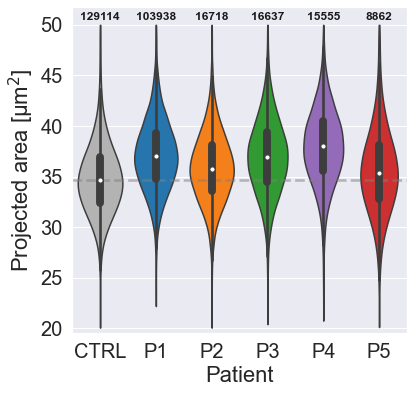

In [40]:
fontsize=20

fig, ax = plot_violins(df_rbc, 'patient_label', 'area_um',
                       order=patient_labels,
                       pal='chac_paper_custom',
                       fontsize_labels=fontsize)
ax.set_ylabel(r"Projected area [µm$^2$]")
ax.set_xlabel("Patient", fontsize=fontsize+2)

ax.set_ylim(19.5,51.75)

# add number of observations per violin
nobs = df_rbc['patient_label'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
# add it to the plot
pos = range(len(nobs))
text_y_position = 50.5

for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            text_y_position,
            nobs[tick],
            horizontalalignment='center',
            size='medium',
            color='k',
            weight='semibold')

In [41]:
save_name = "fig1F_RBC_baseline_area"
savepath = os.path.join(savefolder, save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

Statistics

In [10]:
para = 'area_um'

Result = linmixmod(xs=df_rbc[para], treatment=df_rbc['treatment'],
                   #df_rbc['repeat'] begins at 0, but 0 values are excluded from the computation
                   timeunit=df_rbc['repeat']+1, model='lmm')

print("p-Value (Likelihood Ratio Test):", Result["p-Value (Likelihood Ratio Test)"])
print("Estimate:", Result["Estimate"])
print("Std. Error (Estimate):", Result["Std. Error (Estimate)"])
print("Fixed Effect:", Result["Fixed Effect"])
print("Std. Error (Fixed Effect)", Result["Std. Error (Fixed Effect)"])

p-Value (Likelihood Ratio Test): 0.00330963172390973
Estimate: 34.7950257450977
Std. Error (Estimate): 0.231927862339469
Fixed Effect: 1.9086524285161
Std. Error (Fixed Effect) 0.489772119197715


```
p-Value (Likelihood Ratio Test): 0.00330963024378934
Estimate: 34.7950257451201
Std. Error (Estimate): 0.231929804369913
Fixed Effect: 1.90865253031672
Std. Error (Fixed Effect) 0.489752162986003
```

#### Deformation

Text(0.5, 0, 'Patient')

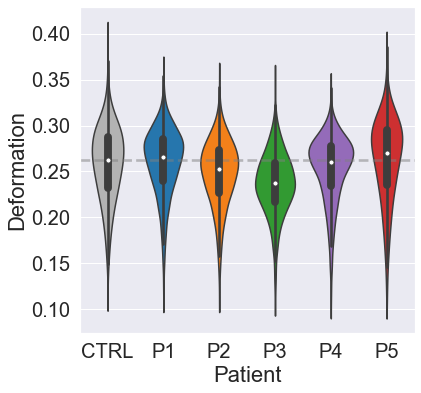

In [11]:
fontsize=20

fig, ax = plot_violins(df_rbc, 'patient_label', 'deform',
                       order=patient_labels,
                       pal='chac_paper_custom',
                       fontsize_labels=fontsize)
ax.set_xlabel("Patient", fontsize=fontsize+2)

In [12]:
save_name = "fig1G_RBC_baseline_deformation"
savepath = os.path.join(savefolder, save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

Calculate p-value and other statistics

In [13]:
para = 'deform'

Result = linmixmod(xs=df_rbc[para], treatment=df_rbc['treatment'],
                   #df_rbc['repeat'] begins at 0, but 0 values are excluded from the computation
                   timeunit=df_rbc['repeat']+1, model='lmm')

print("p-Value (Likelihood Ratio Test):", Result["p-Value (Likelihood Ratio Test)"])
print("Estimate:", Result["Estimate"])
print("Std. Error (Estimate):", Result["Std. Error (Estimate)"])
print("Fixed Effect:", Result["Fixed Effect"])
print("Std. Error (Fixed Effect)", Result["Std. Error (Fixed Effect)"])

p-Value (Likelihood Ratio Test): 0.139245390924611
Estimate: 0.259358320302857
Std. Error (Estimate): 0.00213584459877687
Fixed Effect: -0.00745073293252609
Std. Error (Fixed Effect) 0.00513733930871573


```
p-Value (Likelihood Ratio Test): 0.139245389471824
Estimate: 0.259358319868594
Std. Error (Estimate): 0.0021357200925621
Fixed Effect: -0.00745073222179398
Std. Error (Fixed Effect) 0.00513705367383118
```

### Panels H and I

Lymphocyte files

In [30]:
lympho_folder = r"data\RTfDC\WBC\Analysis-ShapeOut\data_export_lymphos"

CTRL_file = "SO2-export_0_20170803_CTRL_WBCs.rtdc"
VS_file = "SO2-export_1_20170627_VS_WBC.rtdc"
VL_file = "SO2-export_2_20170711_VL_WBC.rtdc"
RS_file = "SO2-export_3_20170809_RS_WBC.rtdc"
LM_file = "SO2-export_4_20170907_LM_0w_WBC.rtdc"
KM_file = "SO2-export_5_20170829_KM_WBC.rtdc"

lympho_files = [CTRL_file, VS_file, VL_file, RS_file, KM_file, LM_file]

Create dataframe for lymphocytes

In [31]:
df_lympho = pd.DataFrame()

for index, file in enumerate(lympho_files):

    ds = dclab.new_dataset(os.path.join(lympho_folder,file))
    df = pd.DataFrame()

    for feat in ds.features:
        if feat in dclab.definitions.scalar_feature_names:
            df[feat] = ds[feat]

    df['patient'] = file.split("_")[3]

    if "CTRL" in file:
        df['treatment'] = 'Control'
    else:
        df['treatment'] = 'Treatment'

    df['repeat'] = index

    df_lympho = df_lympho.append(df, ignore_index=True)

df_lympho['patient_label'] = np.nan

patients = ['CTRL', 'VS', 'VL', 'RS', 'LM', 'KM']
patient_labels = ['CTRL', 'P1', 'P2', 'P3', 'P4', 'P5']
for patient, patient_label in zip(patients, patient_labels):
    ind = df_lympho['patient'] == patient
    df_lympho['patient_label'][ind] = patient_label

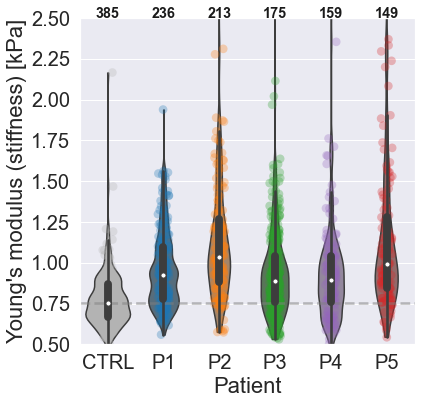

In [32]:
fontsize=20

fig, ax = plot_violins(df_lympho, 'patient_label', 'emodulus',
                       order=patient_labels,
                       pal='chac_paper_custom',
                       fontsize_labels=fontsize,
                       stripplot=True, saturation=.25)
ax.set_xlabel("Patient", fontsize=fontsize+2)
ax.set_ylabel("Young's modulus (stiffness) [kPa]", fontsize=fontsize+2)
ax.set_ylim(0.5,2.5)

# add number of observations per violin
nobs = df_lympho['patient_label'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
# add it to the plot
pos = range(len(nobs))
text_y_position = 2.5

for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            text_y_position,
            nobs[tick],
            horizontalalignment='center',
            size='large',
            color='k',
            weight='semibold')

In [33]:
save_name = "fig1H_WBC_lympho_baseline_emod"
savepath = os.path.join(savefolder, save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

Statistical tests

In [18]:
para = 'emodulus'

Result = linmixmod(xs=df_lympho[para], treatment=df_lympho['treatment'],
                   #df_lympho['repeat'] begins at 0, but 0 values are excluded from the computation
                   timeunit=df_lympho['repeat']+1, model='lmm')

print("p-Value (Likelihood Ratio Test):", Result["p-Value (Likelihood Ratio Test)"])
print("Estimate:", Result["Estimate"])
print("Std. Error (Estimate):", Result["Std. Error (Estimate)"])
print("Fixed Effect:", Result["Fixed Effect"])
print("Std. Error (Fixed Effect)", Result["Std. Error (Fixed Effect)"])

p-Value (Likelihood Ratio Test): 0.0185838785945076
Estimate: 0.780505628348731
Std. Error (Estimate): 0.383621185643171
Fixed Effect: 0.24246450604623
Std. Error (Fixed Effect) 0.386715491450513


```
p-Value (Likelihood Ratio Test): 0.0185838785945788
Estimate: 0.780505628348649
Std. Error (Estimate): 0.383553673273846
Fixed Effect: 0.242465466362725
Std. Error (Fixed Effect) 0.38665144907393
```

Create dataframe for myelocytes

In [34]:
myelo_folder = r"data\RTfDC\WBC\Analysis-ShapeOut\data_export_myelos"
CTRL_file = "SO2-export_0_20170803_CTRL_WBCs.rtdc"
VS_file = "SO2-export_1_20170627_VS_WBC.rtdc"
VL_file = "SO2-export_2_20170711_VL_WBC.rtdc"
RS_file = "SO2-export_3_20170809_RS_WBC.rtdc"
LM_file = "SO2-export_4_20170907_LM_0w_WBC.rtdc"
KM_file = "SO2-export_5_20170829_KM_WBC.rtdc"

myelo_files = [CTRL_file, VS_file, VL_file, RS_file, KM_file, LM_file]

In [35]:
df_myelo = pd.DataFrame()

for index, file in enumerate(myelo_files):

    ds = dclab.new_dataset(os.path.join(myelo_folder,file))
    df = pd.DataFrame()

    for feat in ds.features:
        if feat in dclab.definitions.scalar_feature_names:
            df[feat] = ds[feat]

    df['patient'] = file.split("_")[3]

    if "CTRL" in file:
        df['treatment'] = 'Control'
    else:
        df['treatment'] = 'Treatment'

    df['repeat'] = index

    df_myelo = df_myelo.append(df, ignore_index=True)

df_myelo['patient_label'] = np.nan

patients = ['CTRL', 'VS', 'VL', 'RS', 'LM', 'KM']
patient_labels = ['CTRL', 'P1', 'P2', 'P3', 'P4', 'P5']
for patient, patient_label in zip(patients, patient_labels):
    ind = df_myelo['patient'] == patient
    df_myelo['patient_label'][ind] = patient_label

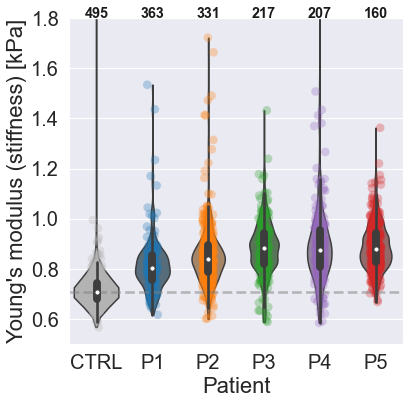

In [36]:
fontsize=20
fig, ax = plot_violins(df_myelo, 'patient_label', 'emodulus',
                       order=patient_labels,
                       pal='chac_paper_custom',
                       fontsize_labels=fontsize,
                       stripplot=True, saturation=.25)
ax.set_xlabel("Patient", fontsize=fontsize+2)
ax.set_ylabel("Young's modulus (stiffness) [kPa]", fontsize=fontsize+2)
ax.set_ylim(.5,1.8)

# add number of observations per violin
nobs = df_myelo['patient_label'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
# add it to the plot
pos = range(len(nobs))
text_y_position = 1.8

for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            text_y_position,
            nobs[tick],
            horizontalalignment='center',
            size='large',
            color='k',
            weight='semibold')

In [37]:
save_name = "fig1I_WBC_myelo_baseline_emod"
savepath = os.path.join(savefolder, save_name)
fig.tight_layout()
fig.savefig(savepath+".pdf", dpi=900, format='pdf')

In [23]:
para = 'emodulus'

Result = linmixmod(xs=df_myelo[para], treatment=df_myelo['treatment'],
                   #df_myelo['repeat'] begins at 0, but 0 values are excluded from the computation
                   timeunit=df_myelo['repeat']+1, model='lmm')

print("p-Value (Likelihood Ratio Test):", Result["p-Value (Likelihood Ratio Test)"])
print("Estimate:", Result["Estimate"])
print("Std. Error (Estimate):", Result["Std. Error (Estimate)"])
print("Fixed Effect:", Result["Fixed Effect"])
print("Std. Error (Fixed Effect)", Result["Std. Error (Fixed Effect)"])

p-Value (Likelihood Ratio Test): 0.00706240810654952
Estimate: 0.723401625492519
Std. Error (Estimate): 0.258049356018904
Fixed Effect: 0.146437880098183
Std. Error (Fixed Effect) 0.258412927980769


```
p-Value (Likelihood Ratio Test): 0.00706240810655399
Estimate: 0.723401625519808
Std. Error (Estimate): 0.258067695307158
Fixed Effect: 0.146437923010934
Std. Error (Fixed Effect) 0.258431194852495
```